# Logistic Regression (로지스틱 회귀)

- 로지스틱 회귀는 다음과 같은 상황에서 사용할 수 있음
  1. binary target을 모델링하는 경우
  2. 예측 확률을 알고 싶은 경우
  3. **해석 가능한 모델**을 얻고자 하는 경우
  4. 클래스를 선형으로 분리 가능한 경우

## Assumptions
1. 관측치들 간 독립성: 데이터의 샘플들은 랜덤하게 얻어져야 함. (반복적 측정 X, 시간 및 공간에 따른 상관관계 X)
  - 본 실습에서 활용하는 타이타닉 데이터의 경우 개별 승객 기록으로 구성되므로 자동 충족
2. 잔차 간 등분산성
3. 독립 변수와 log odds 간의 linearity (R에서는 car package에 [Box-Tidwell](https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290) 수행하는 라이브러리 제공)
4. 이상치가 존재하지 않아야 함
- 추가적으로, 적당한 수의 샘플이 존재해야 함.
- 또한, independent variables가 너무 많을 경우 일반화 성능이 감소할 수 있음.
- 확인하는 방법에 대한 자세한 설명 [참고](https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290)

1. 관측치들 간 독립성 - 랜덤하게 얻어진 샘플이므로 만족
2. 이상치 - 제거해줌
3. 잔차 간 등분산성
4. 독립 변수와 log odds 간의 linearity 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix,classification_report,precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import plotly 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Step 1. Data Preprocessing

- dataset: [Heart Disease] from kaggle

#### 1.1 관측치들 간 독립성
- 랜덤하게 얻어졌고, 시/공간적 관계없으므로 독립이다

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/Shareddrives/컨디션난조,분위기고조/실습과제/7주차/[컨디션난조 분위기고조] week7_LogisticRegression_데이터.csv")

In [ ]:
data.shape # (행, 열)

(1025, 14)

- age
- sex (1 = male; 0 = female)
- cp = chest pain type (4 values)
- resting blood pressure
- serum cholestoral in mg/dl
- fasting blood sugar > 120 mg/dl
(1 = true; 0 = false)
- restecg = resting electrocardiographic results (values 0,1,2)
- maximum heart rate achieved
- exercise induced angina(1 = yes; 0 = no)
- oldpeak = ST depression induced by exercise relative to rest
- the slope of the peak exercise ST segment
- number of major vessels (0-3) colored by flourosopy
- thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

연속형 변수 = 'age', 'chol', 'trestbps', 'thalach', 'oldpeak' 

범주형 변수 = 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'

In [ ]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [ ]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

#### 1.2 outlier detection
- 이상치가 존재하지 않아야 함.
수치형 변수에 대하여 이상치 제거

In [ ]:
numeric_feature = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cate_feature = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [ ]:
def outlier_iqr(data, column): 
    fraud = data[column]
    global lower, upper       
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)
    iqr = q75 - q25    
    # outlier cutoff     
    cut_off = iqr * 1.5          
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off        
    
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower] 

    outlier_index = fraud[(fraud < lower) | (fraud > upper)].index
    data.drop(outlier_index, axis=0, inplace = True)
    # 이상치 총 개수 구하기
    print(i, '의 총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다.')
    
    return data

In [ ]:
for i in numeric_feature :
    outlier_iqr(data, i)

age 의 총 이상치 개수는 0 이다.
trestbps 의 총 이상치 개수는 30 이다.
chol 의 총 이상치 개수는 16 이다.
thalach 의 총 이상치 개수는 4 이다.
oldpeak 의 총 이상치 개수는 11 이다.


In [ ]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


*1025*->965으로 행 감소

#### Standard Scaling
연속형 변수들에 대하여 스케일링 진행

In [ ]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
data_std = standard_scaler.fit_transform(data[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']])

In [ ]:
data['age'] = data_std[:, 0]
data['trestbps'] = data_std[:, 1]
data['chol'] = data_std[:, 2]
data['thalach'] = data_std[:, 3]
data['oldpeak'] = data_std[:, 4]

In [ ]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,-0.225117,1,0,-0.323738,-0.668600,0,1,0.814355,0,0.013116,2,2,3,0
1,-0.115680,1,0,0.655807,-0.868282,1,0,0.241913,1,2.009554,0,0,3,0
2,1.744742,1,0,0.982322,-1.511704,0,1,-1.079107,1,1.534211,0,0,3,0
3,0.759812,1,0,1.178231,-0.868282,0,1,0.506117,0,-0.937568,2,1,3,0
4,0.869249,0,0,0.525201,1.150729,1,1,-1.915754,0,0.868732,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.540939,1,1,0.655807,-0.468918,0,1,0.638219,1,-0.937568,2,0,2,1
1021,0.650376,1,0,-0.323738,0.351999,0,0,-0.374563,1,1.724348,1,1,3,0
1022,-0.772300,1,0,-1.303283,0.729177,0,0,-1.387345,1,0.013116,1,1,2,0
1023,-0.443990,0,0,-1.303283,0.263251,0,0,0.418049,0,-0.937568,2,0,2,1


# Step 2. EDA

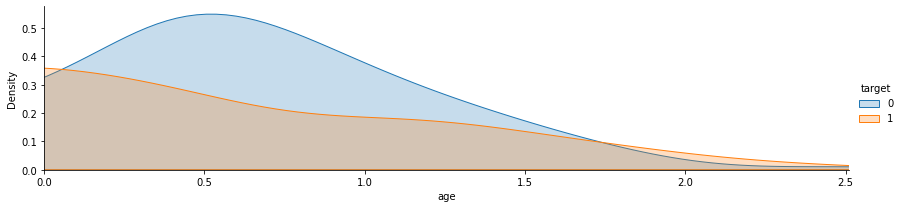

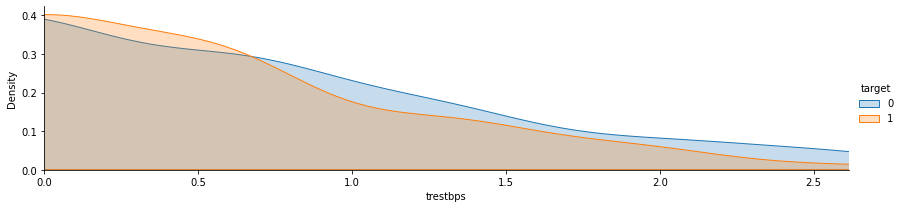

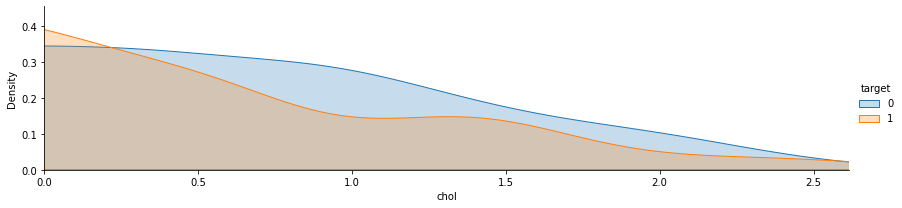

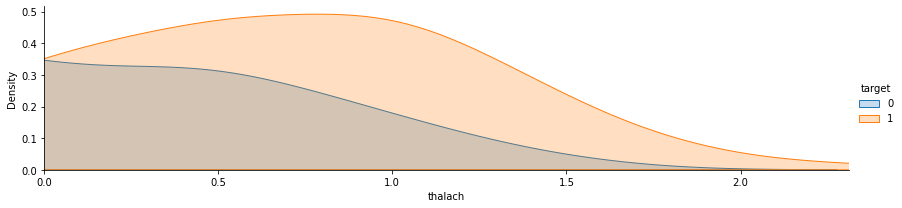

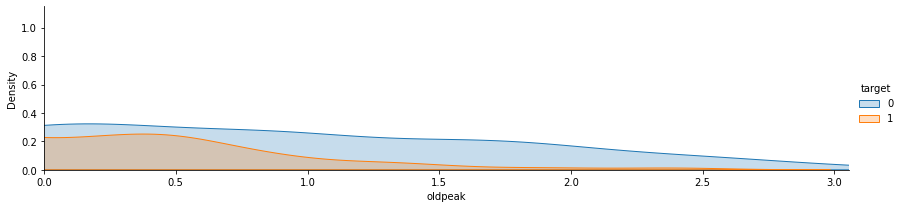

In [ ]:
# 연속형 변수에 따른 target 비교

import matplotlib.pyplot as plt
import seaborn as sns

for i in numeric_feature :
    facet = sns.FacetGrid(data, hue="target", aspect=4)
    facet.map(sns.kdeplot, i, shade=True)
    facet.set(xlim=(0, data[i].max()))
    facet.add_legend()

sns.axes_style("darkgrid")
plt.show()

In [ ]:
# 특정 feature에 따른 target 비교 (0: 사망, 1: 생존) 함수
def bar_chart(feature):
    target = data[data['target']==1][feature].value_counts()
    dead = data[data['target']==0][feature].value_counts()
    df_survived = pd.DataFrame([target,dead])
    df_survived.index = ['target','Dead']
    df_survived.plot(kind='bar',stacked=True, figsize=(10,5))

sex
cp
fbs
restecg
exang
slope
ca
thal


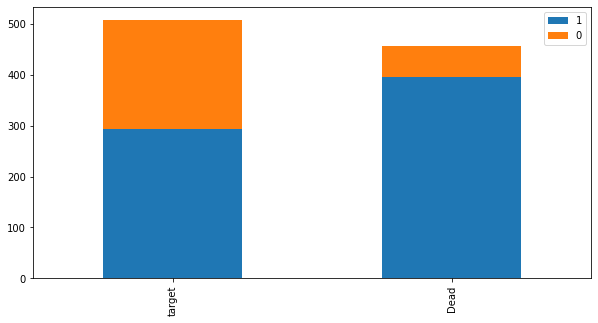

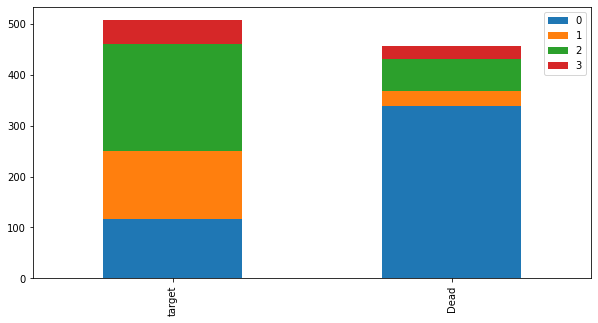

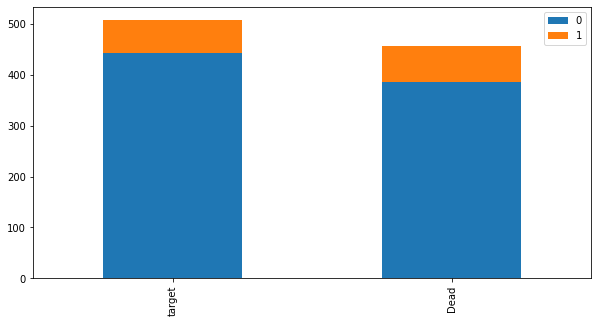

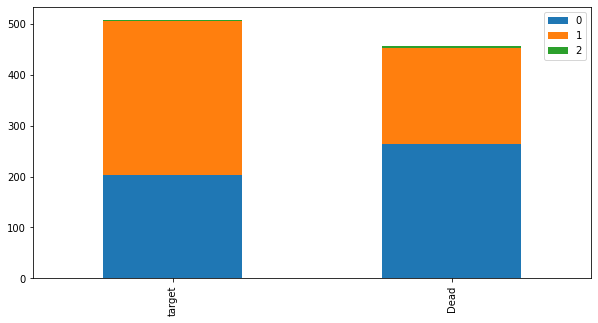

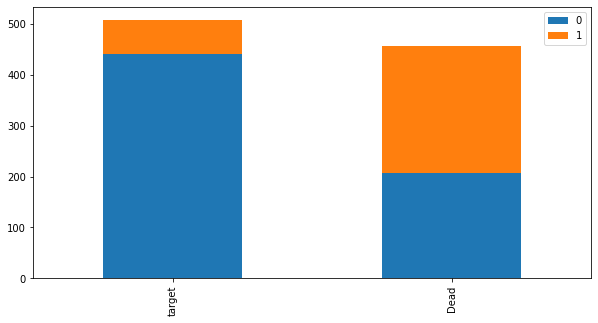

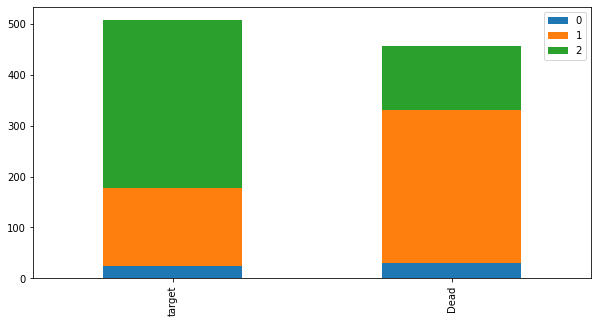

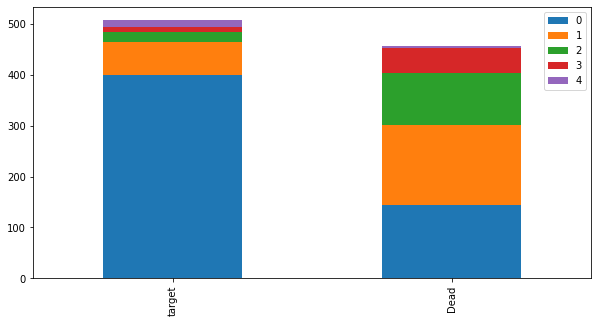

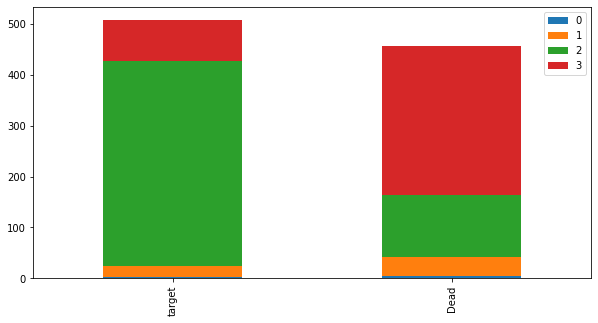

In [ ]:
for i in cate_feature :
    print(i)
    bar_chart(i)
    data.groupby([i])['target'].agg(lambda x: x.sum()/x.count()) # heart disease 확진 확률

범주형 변수 중, 각 class에 따른 target의 차이를 유의미하게 확인할 수 없는 'restecg', 'ca', 'thal' 제거

In [ ]:
data.drop(['restecg', 'ca', 'thal'], axis = 1, inplace = True)

In [ ]:
data

,age,sex,cp,trestbps,chol,fbs,thalach,exang,oldpeak,slope,target
0,-0.225117,1,0,-0.323738,-0.668600,0,0.814355,0,0.013116,2,0
1,-0.115680,1,0,0.655807,-0.868282,1,0.241913,1,2.009554,0,0
2,1.744742,1,0,0.982322,-1.511704,0,-1.079107,1,1.534211,0,0
3,0.759812,1,0,1.178231,-0.868282,0,0.506117,0,-0.937568,2,0
4,0.869249,0,0,0.525201,1.150729,1,-1.915754,0,0.868732,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1020,0.540939,1,1,0.655807,-0.468918,0,0.638219,1,-0.937568,2,1
1021,0.650376,1,0,-0.323738,0.351999,0,-0.374563,1,1.724348,1,0
1022,-0.772300,1,0,-1.303283,0.729177,0,-1.387345,1,0.013116,1,0
1023,-0.443990,0,0,-1.303283,0.263251,0,0.418049,0,-0.937568,2,1


범주형 변수 더미변수화

In [ ]:
cate_feature = ['sex', 'cp', 'fbs', 'exang', 'slope']
for i in cate_feature :
    data = pd.get_dummies(data, columns = [i], drop_first=True) # 두 변수 간 correaltion =1이 되는 것을 방지

In [ ]:
data.shape

(964, 14)

In [ ]:
data

,age,trestbps,chol,thalach,oldpeak,target,sex_1,cp_1,cp_2,cp_3,fbs_1,exang_1,slope_1,slope_2
0,-0.225117,-0.323738,-0.668600,0.814355,0.013116,0,1,0,0,0,0,0,0,1
1,-0.115680,0.655807,-0.868282,0.241913,2.009554,0,1,0,0,0,1,1,0,0
2,1.744742,0.982322,-1.511704,-1.079107,1.534211,0,1,0,0,0,0,1,0,0
3,0.759812,1.178231,-0.868282,0.506117,-0.937568,0,1,0,0,0,0,0,0,1
4,0.869249,0.525201,1.150729,-1.915754,0.868732,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.540939,0.655807,-0.468918,0.638219,-0.937568,1,1,1,0,0,0,1,0,1
1021,0.650376,-0.323738,0.351999,-0.374563,1.724348,0,1,0,0,0,0,1,1,0
1022,-0.772300,-1.303283,0.729177,-1.387345,0.013116,0,1,0,0,0,0,1,1,0
1023,-0.443990,-1.303283,0.263251,0.418049,-0.937568,1,0,0,0,0,0,0,0,1


In [ ]:
data_pre = data.copy()

In [ ]:
data.drop(['target'], axis = 1, inplace = True)
data['target'] = data_pre['target']
data

,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,exang_1,slope_1,slope_2,target
0,-0.225117,-0.323738,-0.668600,0.814355,0.013116,1,0,0,0,0,0,0,1,0
1,-0.115680,0.655807,-0.868282,0.241913,2.009554,1,0,0,0,1,1,0,0,0
2,1.744742,0.982322,-1.511704,-1.079107,1.534211,1,0,0,0,0,1,0,0,0
3,0.759812,1.178231,-0.868282,0.506117,-0.937568,1,0,0,0,0,0,0,1,0
4,0.869249,0.525201,1.150729,-1.915754,0.868732,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.540939,0.655807,-0.468918,0.638219,-0.937568,1,1,0,0,0,1,0,1,1
1021,0.650376,-0.323738,0.351999,-0.374563,1.724348,1,0,0,0,0,1,1,0,0
1022,-0.772300,-1.303283,0.729177,-1.387345,0.013116,1,0,0,0,0,1,1,0,0
1023,-0.443990,-1.303283,0.263251,0.418049,-0.937568,0,0,0,0,0,0,0,1,1


In [ ]:
X = data.iloc[:, :13]
X

,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,exang_1,slope_1,slope_2
0,-0.225117,-0.323738,-0.668600,0.814355,0.013116,1,0,0,0,0,0,0,1
1,-0.115680,0.655807,-0.868282,0.241913,2.009554,1,0,0,0,1,1,0,0
2,1.744742,0.982322,-1.511704,-1.079107,1.534211,1,0,0,0,0,1,0,0
3,0.759812,1.178231,-0.868282,0.506117,-0.937568,1,0,0,0,0,0,0,1
4,0.869249,0.525201,1.150729,-1.915754,0.868732,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.540939,0.655807,-0.468918,0.638219,-0.937568,1,1,0,0,0,1,0,1
1021,0.650376,-0.323738,0.351999,-0.374563,1.724348,1,0,0,0,0,1,1,0
1022,-0.772300,-1.303283,0.729177,-1.387345,0.013116,1,0,0,0,0,1,1,0
1023,-0.443990,-1.303283,0.263251,0.418049,-0.937568,0,0,0,0,0,0,0,1


In [ ]:
y = data['target']

- 다중공선성 확인

In [ ]:
# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(data):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return(vif)

calc_vif(X)

,variables,VIF
0,age,1.367339
1,trestbps,1.139003
2,chol,1.083763
3,thalach,1.723949
4,oldpeak,1.530506
5,sex_1,3.463685
6,cp_1,1.609346
7,cp_2,1.814443
8,cp_3,1.284037
9,fbs_1,1.199304


모든 변수의 VIF값이 10 미만이므로 다중공선성이 없다고 판단

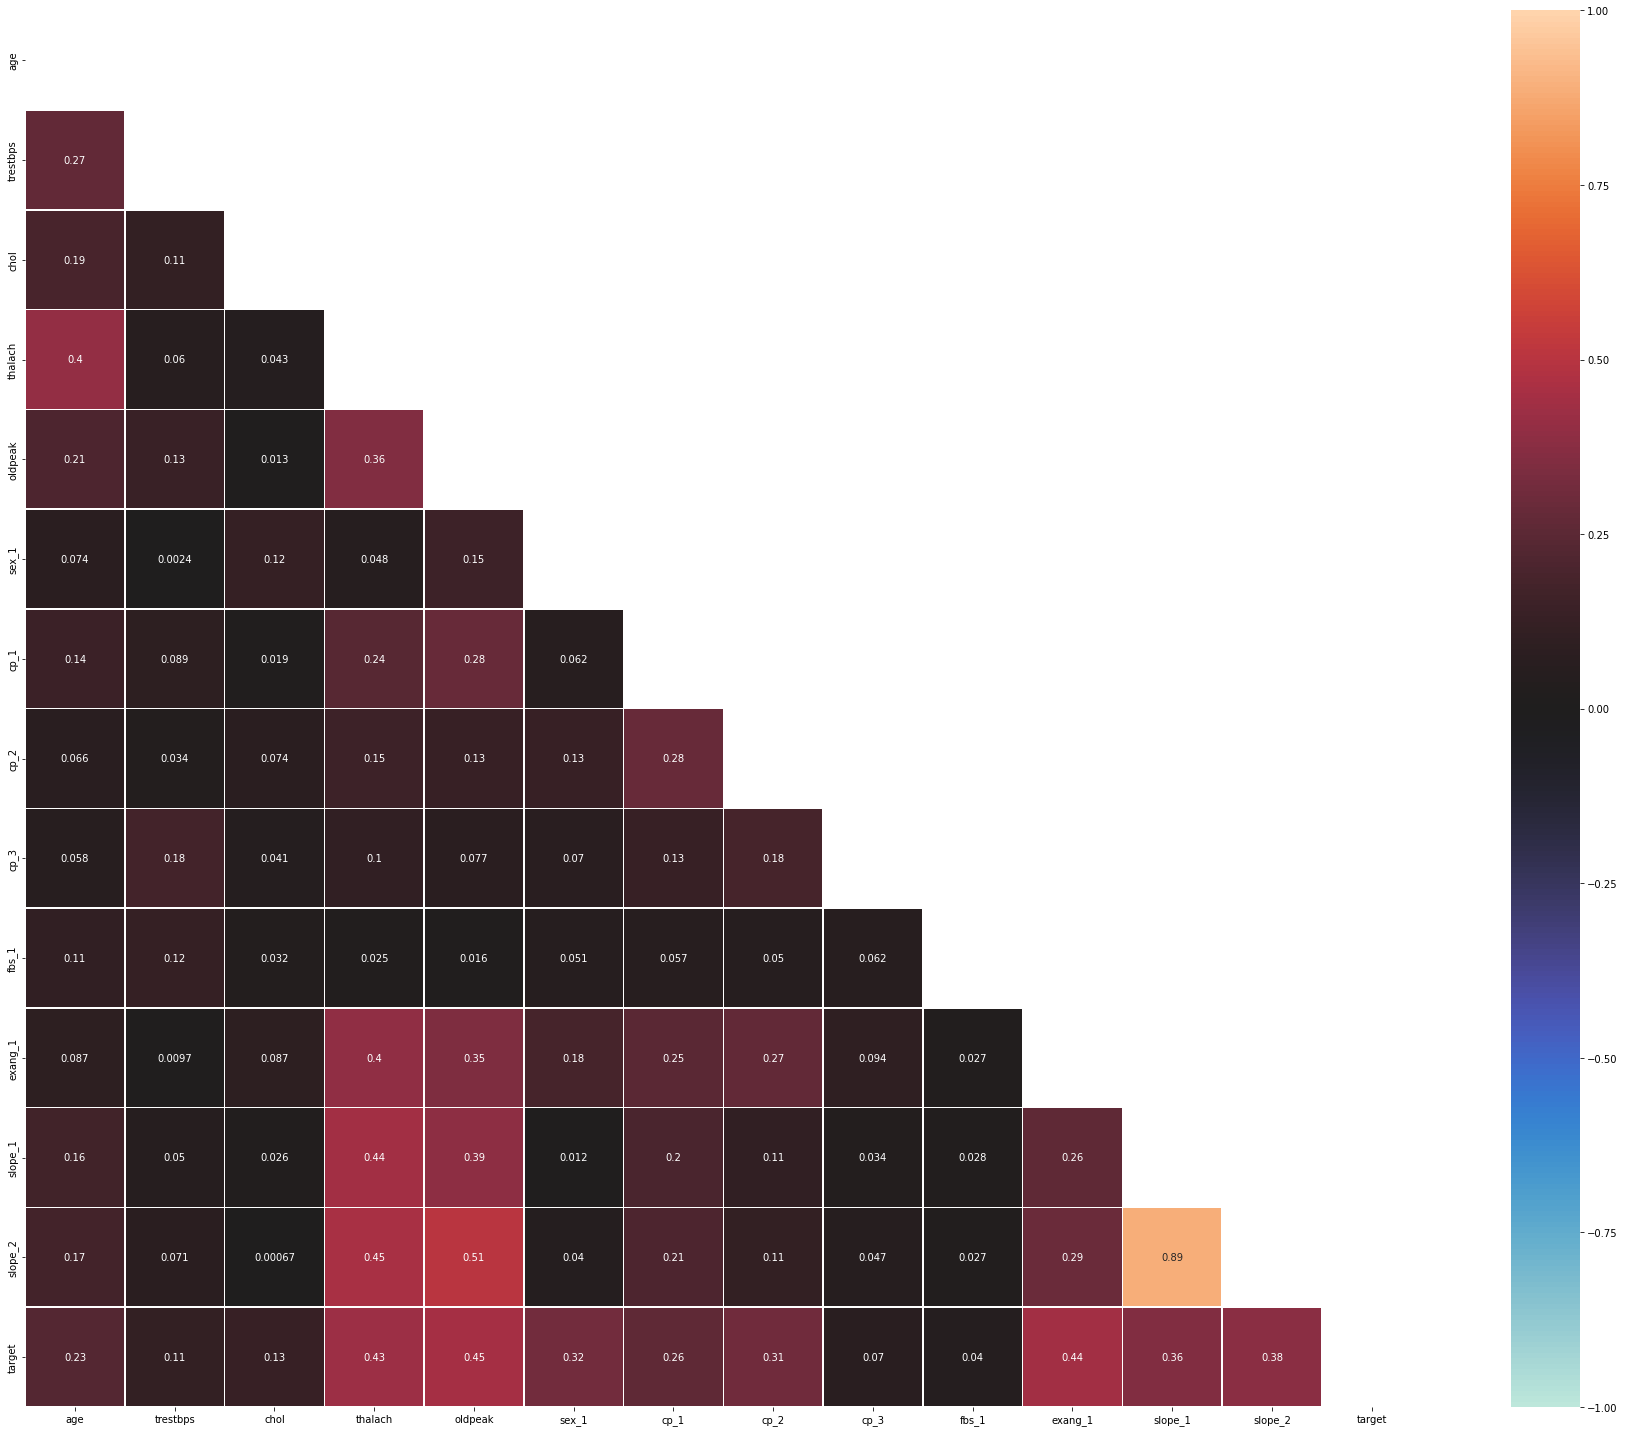

In [ ]:
X_corr = data.corr().abs()
mask = np.zeros_like(X_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 20))
sns.heatmap(X_corr, mask=mask, vmin=-1, vmax=1, annot=True,
            square=True, center=0, linewidths=.5)
plt.tight_layout()

target과 각 독립변수들 간의 상관계수

Target variance와의 상관관계를 확인

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f408a78d0>,
      dtype=object)

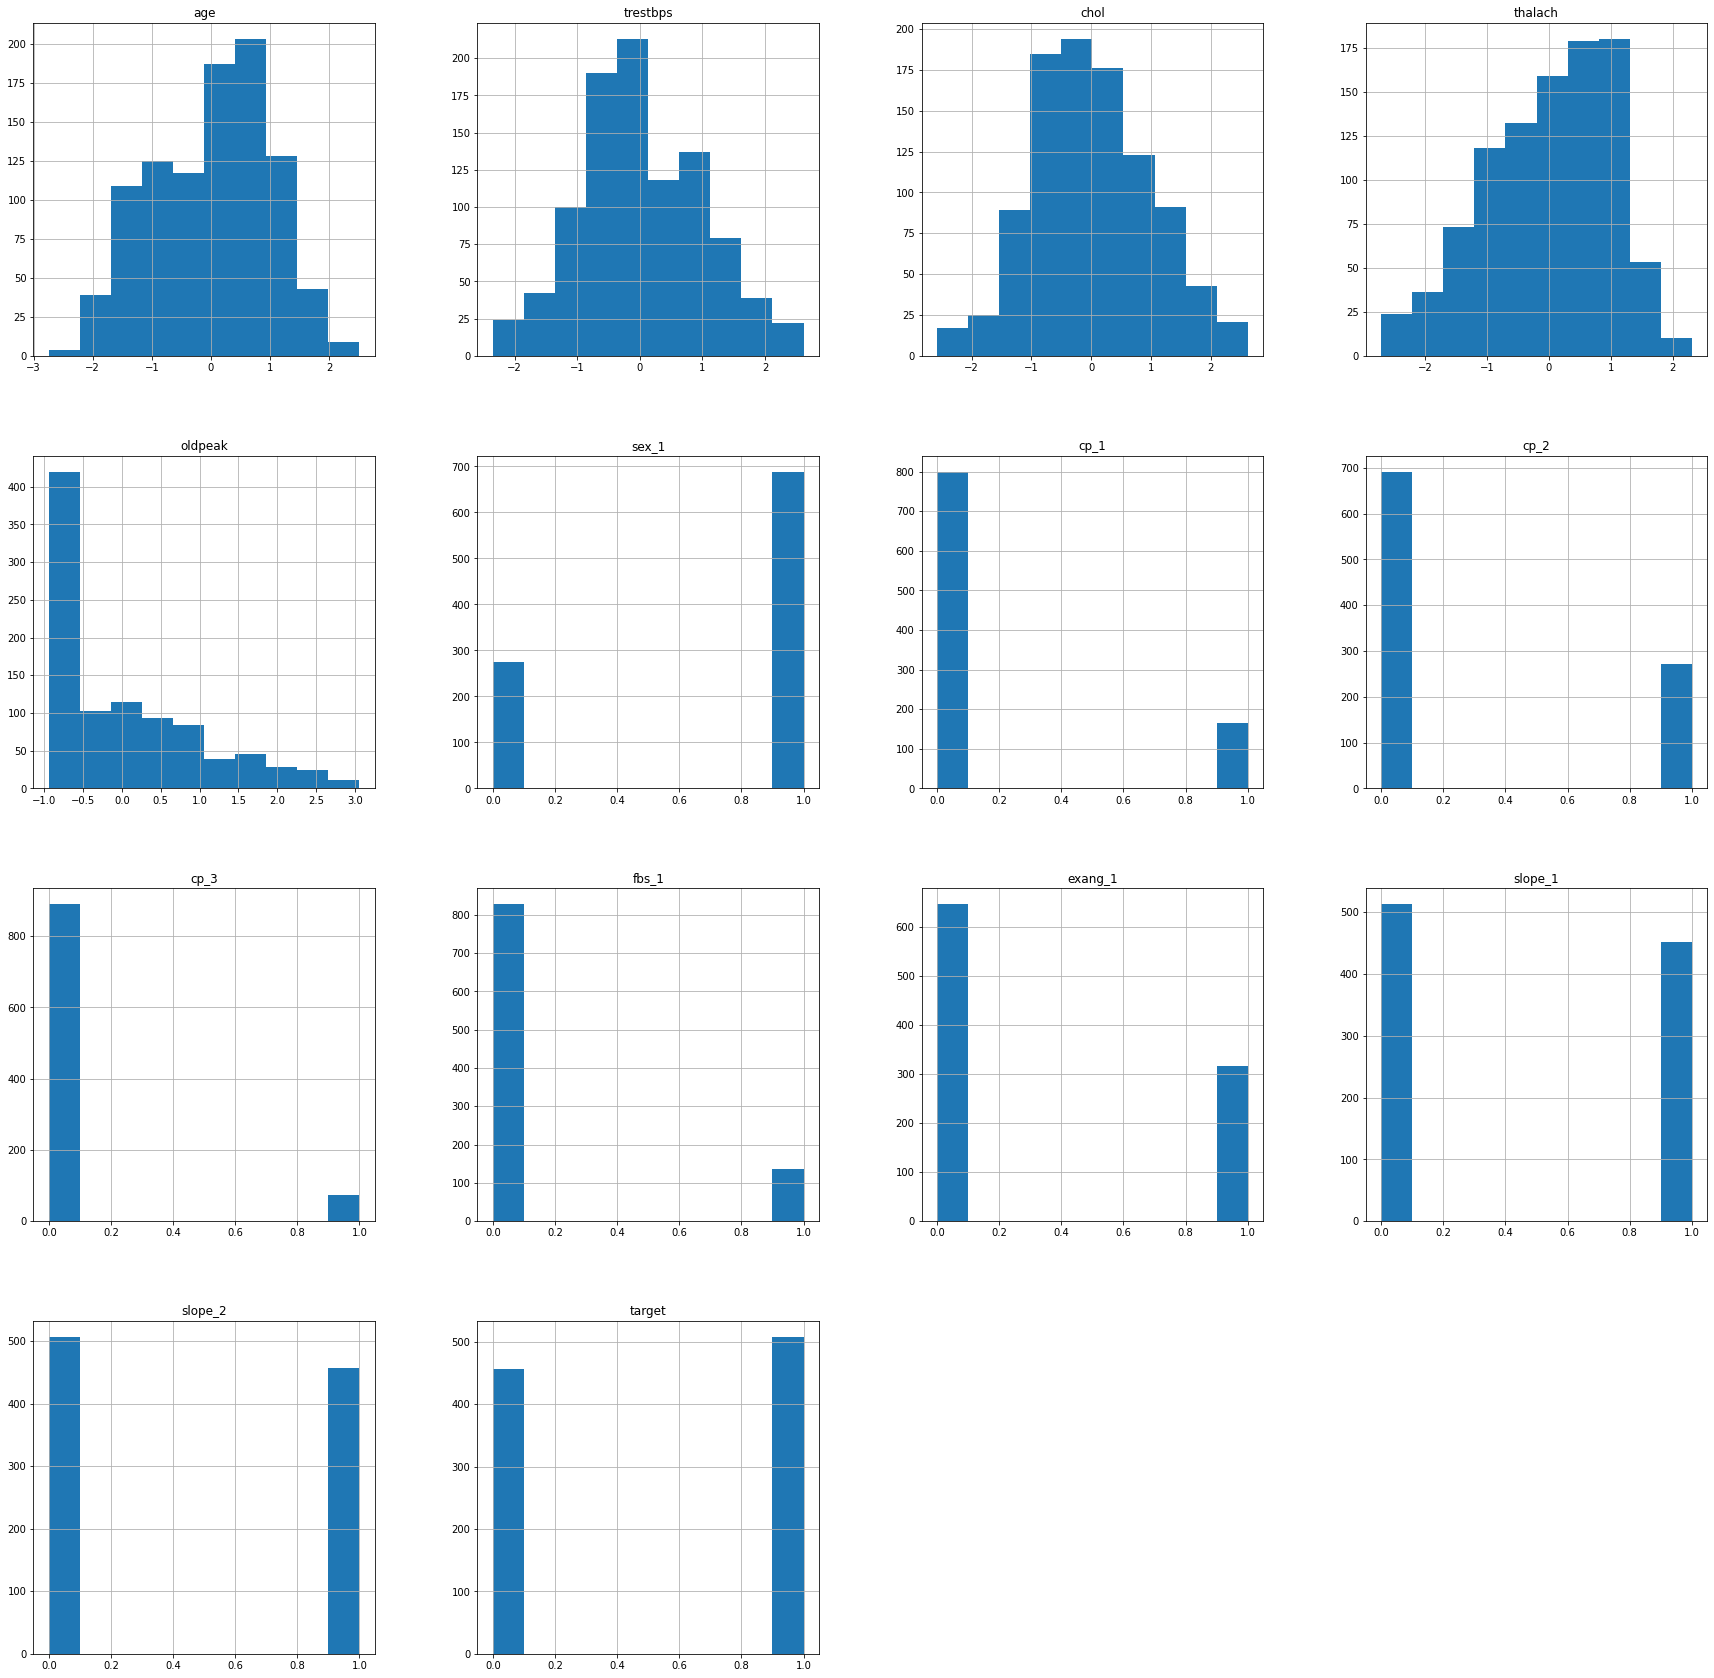

In [ ]:
data.hist(figsize = (30,30))

# Step 3. Logistic Regression 
- 설명이 용이함
  - 오즈(odds; $\frac{p}{1-p}$)의 관점에서 해석될 수 있음 (실패에 비해 성공할 확률의 비)
  - $exp(\beta_1)$: 나머지 변수$(x_2,\cdots,x_k)$가 주어질 때 $x_1$이 한 단위 증가할 때마다 성공(Y)의 오즈가 몇 배 증가하는지를 나타내는 값
- 좋은 성능을 기대하기 어려울 수도 있음
- `statsmodel`, `sklearn`
  - `statsmodel`: p-value 등 모델에 대한 summary 정보 제공

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 312)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 312, stratify=y_train)
print("train set:",x_train.shape)
print("valid set:",x_valid.shape)
print("test set:",x_test.shape)

train set: (616, 13)
valid set: (155, 13)
test set: (193, 13)


y value 의 개수 차이가 거의 없으므로 UnderSampling은 필요없다.

In [ ]:
y_train.value_counts()

1    329
0    287
Name: target, dtype: int64

create the polynomial features

In [ ]:
import statsmodels.api as sm
x_train = sm.add_constant(x_train)
x_valid = sm.add_constant(x_valid)
x_test = sm.add_constant(x_test)

In [ ]:
x_train.shape

(616, 14)

In [ ]:
y_train.shape

(616,)

In [ ]:
model_sm = sm.Logit(y_train, x_train).fit()

Optimization terminated successfully.
         Current function value: 0.414364
         Iterations 7


# Step 4. Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Probability 값
predict_prob = model_sm.predict(x_valid)

In [ ]:
y_valid.shape

(155,)

- 예측값(fitted)과 잔차(residual)를 비교
- 빨간 실선은 잔차의 추세를 나타냄
- 모든 예측값에서 가운데 점선에 맞추어 잔차가 비슷하게 있어야 하며, 빨간 실선이 점선에서 크게 벗어난다면 예측값에 따라 잔차가 크게 달라짐 = 선형성이 없음

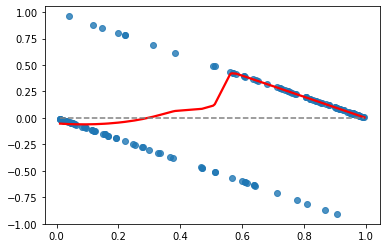

In [ ]:
residual = y_valid - predict_prob

sns.regplot(predict_prob, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([predict_prob.min(), predict_prob.max()], [0, 0], '--', color='grey')

- logit linearity 확인

In [ ]:
X_columns = X.columns
X_columns

Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'sex_1', 'cp_1',
       'cp_2', 'cp_3', 'fbs_1', 'exang_1', 'slope_1', 'slope_2'],
      dtype='object')

In [ ]:
X.dtypes

age         float64
trestbps    float64
chol        float64
thalach     float64
oldpeak     float64
sex_1         uint8
cp_1          uint8
cp_2          uint8
cp_3          uint8
fbs_1         uint8
exang_1       uint8
slope_1       uint8
slope_2       uint8
dtype: object

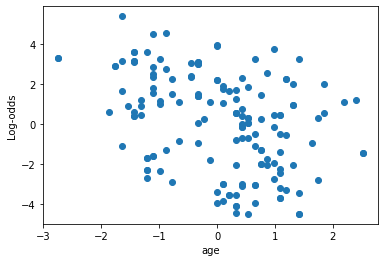

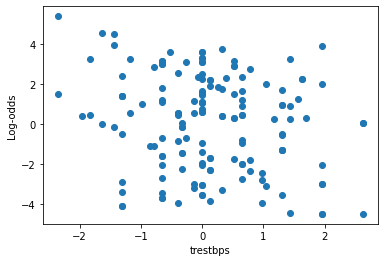

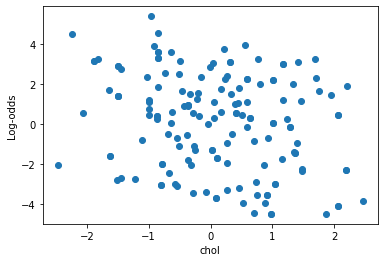

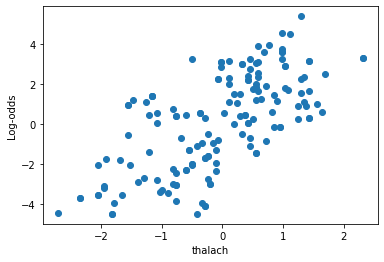

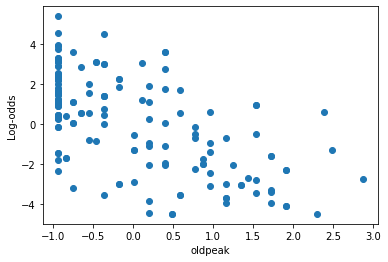

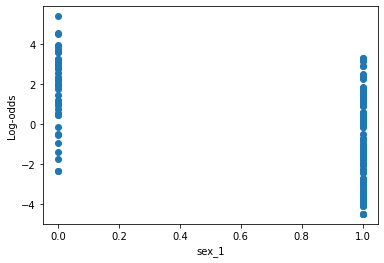

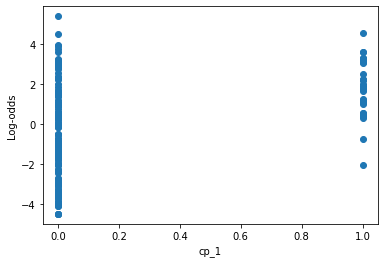

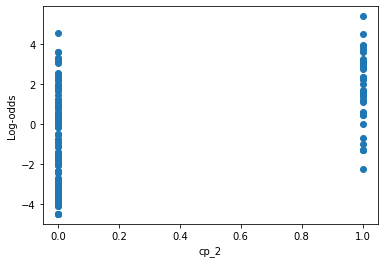

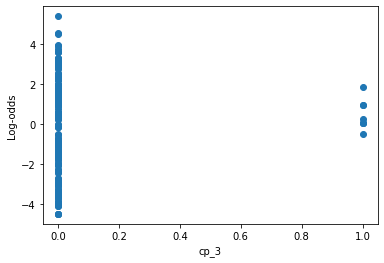

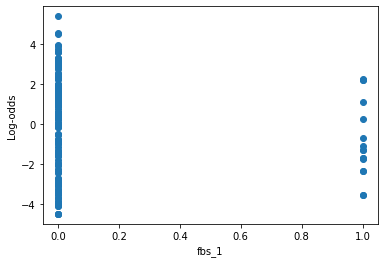

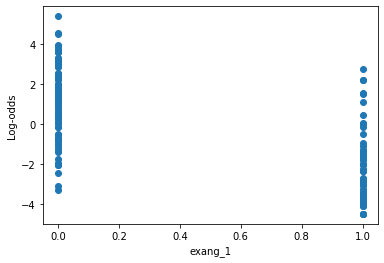

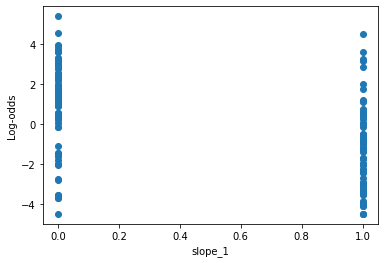

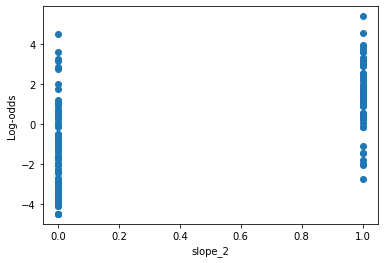

In [ ]:
import numpy as np
# Getting log odds values
log_odds = np.log(predict_prob / (1 - predict_prob))

# Visualize predictor variable vs logit values for Age

for i in X_columns :
    
    plt.scatter(x=x_valid[i].values, y=log_odds)
    plt.xlabel(i)
    plt.ylabel("Log-odds")
    plt.show()
    # sex, cp, fbs, restecg, exang, slope, ca, thal

- 비선형 패턴을 보이는 변수가 있지만, 범주형 변수에 대해 더미변수화 해준 변수들이므로 이후 과정을 진행해주었다.

- cut-off 설정

In [ ]:
# 경계값cut off value에 따라 0,1 값 변환
def change_cutoff(pred_prob_y, cutoff):
    Y_change = pred_prob_y.copy()
    Y_change[Y_change > cutoff] = 1
    Y_change[Y_change <= cutoff] = 0
    return(Y_change.astype(int))

In [ ]:
print(confusion_matrix(y_valid, change_cutoff(predict_prob, 0.4)))
print(" Accuracy:", accuracy_score(y_valid, change_cutoff(predict_prob, 0.4)))
print("Precision:", precision_score(y_valid, change_cutoff(predict_prob, 0.4)))
print("   Recall:", recall_score(y_valid, change_cutoff(predict_prob, 0.4)))
print(" F1 score:", f1_score(y_valid, change_cutoff(predict_prob, 0.4)))

[[54 18]
 [ 8 75]]
 Accuracy: 0.832258064516129
Precision: 0.8064516129032258
   Recall: 0.9036144578313253
 F1 score: 0.8522727272727273


In [ ]:
print(confusion_matrix(y_valid, change_cutoff(predict_prob, 0.5)))
print(" Accuracy:", accuracy_score(y_valid, change_cutoff(predict_prob, 0.5)))
print("Precision:", precision_score(y_valid, change_cutoff(predict_prob, 0.5)))
print("   Recall:", recall_score(y_valid, change_cutoff(predict_prob, 0.5)))
print(" F1 score:", f1_score(y_valid, change_cutoff(predict_prob, 0.5)))

[[57 15]
 [ 8 75]]
 Accuracy: 0.8516129032258064
Precision: 0.8333333333333334
   Recall: 0.9036144578313253
 F1 score: 0.8670520231213873


In [ ]:
print(confusion_matrix(y_valid, change_cutoff(predict_prob, 0.6)))
print(" Accuracy:", accuracy_score(y_valid, change_cutoff(predict_prob, 0.6)))
print("Precision:", precision_score(y_valid, change_cutoff(predict_prob, 0.6)))
print("   Recall:", recall_score(y_valid, change_cutoff(predict_prob, 0.6)))
print(" F1 score:", f1_score(y_valid, change_cutoff(predict_prob, 0.6)))

[[61 11]
 [14 69]]
 Accuracy: 0.8387096774193549
Precision: 0.8625
   Recall: 0.8313253012048193
 F1 score: 0.8466257668711658


In [ ]:
print(confusion_matrix(y_valid, change_cutoff(predict_prob, 0.7)))
print(" Accuracy:", accuracy_score(y_valid, change_cutoff(predict_prob, 0.7)))
print("Precision:", precision_score(y_valid, change_cutoff(predict_prob, 0.7)))
print("   Recall:", recall_score(y_valid, change_cutoff(predict_prob, 0.7)))
print(" F1 score:", f1_score(y_valid, change_cutoff(predict_prob, 0.7)))

[[67  5]
 [21 62]]
 Accuracy: 0.832258064516129
Precision: 0.9253731343283582
   Recall: 0.7469879518072289
 F1 score: 0.8266666666666667


In [ ]:
print(confusion_matrix(y_valid, change_cutoff(predict_prob, 0.8)))
print(" Accuracy:", accuracy_score(y_valid, change_cutoff(predict_prob, 0.8)))
print("Precision:", precision_score(y_valid, change_cutoff(predict_prob, 0.8)))
print("   Recall:", recall_score(y_valid, change_cutoff(predict_prob, 0.8)))
print(" F1 score:", f1_score(y_valid, change_cutoff(predict_prob, 0.8)))

[[69  3]
 [32 51]]
 Accuracy: 0.7741935483870968
Precision: 0.9444444444444444
   Recall: 0.6144578313253012
 F1 score: 0.7445255474452556


- ROC curve: 다양한 threshold에 대한 이진분류기의 성능을 한번에 표시한 그래프
  - TPR: true positive rate
  - FPR: false positive rate
  - 좌측 상단으로 붙어있는 경우 좋은 분류기
- [참고](https://angeloyeo.github.io/2020/08/05/ROC.html)

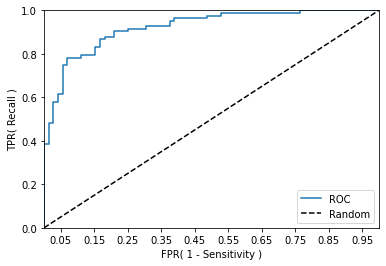

In [ ]:
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test , pred_proba_c1):
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1) # 임곗값에 따른 FPR, TPR 값을 반환 받음. 

    plt.plot(fprs , tprs, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
  
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
  
roc_curve_plot(y_valid, predict_prob)

# Step 5. Interpretation

In [ ]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  616
Model:                          Logit   Df Residuals:                      602
Method:                           MLE   Df Model:                           13
Date:                Fri, 29 Apr 2022   Pseudo R-squ.:                  0.4002
Time:                        14:12:05   Log-Likelihood:                -255.25
converged:                       True   LL-Null:                       -425.55
Covariance Type:            nonrobust   LLR p-value:                 7.366e-65
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2000      0.544      2.207      0.027       0.134       2.266
age           -0.1577      0.134     -1.175      0.240      -0.421       0.105
trestbps      -0.1849      0.117     -1.574      0.115      -0.415       0.045
chol          -0.4557      0.127     -3.598      0.000      -0.704      -0.207
thalach        0.5938      0.153      3.876      0.000       0.293       0.894
oldpeak       -0.5501      0.138     -3.986      0.000      -0.821      -0.280
sex_1         -2.0361      0.291     -7.007      0.000      -2.606      -1.467
cp_1           1.2007      0.346      3.468      0.001       0.522       1.879
cp_2           1.5479      0.287      5.389      0.000       0.985       2.111
cp_3           1.8081      0.403      4.483      0.000       1.018       2.599
fbs_1         -0.0090      0.326     -0.028      0.978      -0.648       0.630
exang_1       -0.7088      0.267     -2.659      0.008      -1.231      -0.186
slope_1       -0.5524      0.506     -1.091      0.275      -1.545       0.440
slope_2        0.2325      0.522      0.445      0.656      -0.790       1.255
==============================================================================
"""

In [ ]:
model_sm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.400     
Dependent Variable: target           AIC:              538.4959  
Date:               2022-04-29 14:12 BIC:              600.4214  
No. Observations:   616              Log-Likelihood:   -255.25   
Df Model:           13               LL-Null:          -425.55   
Df Residuals:       602              LLR p-value:      7.3657e-65
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const          1.2000    0.5438   2.2068  0.0273   0.1342   2.2657
age           -0.1577    0.1342  -1.1755  0.2398  -0.4207   0.1053
trestbps      -0.1849    0.1175  -1.5740  0.1155  -0.4151   0.0453
chol          -0.4557    0.1266  -3.5982  0.0003  -0.7039  -0.2075
thalach        0.5938    0.1532   3.8755  0.0001   0.2935   0.8940
oldpeak       -0.5501    0.1380  -3.9860  0.0001  -0.8206  -0.2796
sex_1         -2.0361    0.2906  -7.0067  0.0000  -2.6057  -1.4666
cp_1           1.2007    0.3463   3.4676  0.0005   0.5220   1.8794
cp_2           1.5479    0.2872   5.3886  0.0000   0.9849   2.1108
cp_3           1.8081    0.4034   4.4825  0.0000   1.0175   2.5987
fbs_1         -0.0090    0.3258  -0.0275  0.9780  -0.6476   0.6296
exang_1       -0.7088    0.2666  -2.6591  0.0078  -1.2312  -0.1864
slope_1       -0.5524    0.5064  -1.0907  0.2754  -1.5449   0.4402
slope_2        0.2325    0.5218   0.4455  0.6560  -0.7903   1.2552
=================================================================

"""

- Reference : sex_0(여성), cp_0(흉부통증유형0), fbs_0(공복혈당 120 mg/dl X), exang_0(협심증 없음), slope_0(피크 운동 ST 세그먼트의 기울기 0)

- Logit(target = 1) = 	1.2000 -0.1577 \* age 	-0.1849 \* trestbps	-0.4557 \* chol +0.5938 \* thalach	-0.5501 \* oldpeak -2.0361 \* sex_1	+	1.2007 \*cp_1 +	1.5479 \*cp_2+1.8081	\*cp_3 -0.0090	\*fbs_1	-0.7088  \*exang_1 -0.5524	 \*slope_1 + 0.2325 \*slope_2

- p-value가 유의수준 0.05 이하인 변수: chol, thalach, oldpeak, sex_1, cp_1, cp_2, cp_3


In [ ]:
# Odds ratio
import numpy as np
np.exp(model_sm.params) 

const       3.319990
age         0.854079
trestbps    0.831201
chol        0.633999
thalach     1.810795
oldpeak     0.576897
sex_1       0.130536
cp_1        3.322460
cp_2        4.701392
cp_3        6.099029
fbs_1       0.991067
exang_1     0.492236
slope_1     0.575594
slope_2     1.261688
dtype: float64

달성된 최대 심박수인 thalach을 먼저 보자면 달성된 최대 심박수가 1단위 높아질 때마다 odds가  1.81배 증가한다고 해석할 수 있다. chol의 경우 1 혈중 콜레스테롤이 1단위 높아질때 0.63배 증가한다. 즉, odds 가 37% 감소한다고 볼 수 있다.  휴식 대비 운동으로 인한 ST 하강의 경우 1단위 증가할때마다 odds가 0.58배 증가, 즉, odds가 42%감소하며, 여성에 비해 남성의 경우 odds가 0.13배 증가(=87% 감소)하는 것도 확인할 수 있었다. 흉부 통증 유형 1,2,3의 경우 모두 흉부통증 유형 0에 비해 그  odds가 각각 3.32, 4.7, 6.1배 증가하는 것을 확인할 수 있었다. 

# Step 6. Test set 평가

위에서 validation set을 통해 선정한 cut-off인 0.5를 기준으로 최종 test dataset에의 모델 성능을 확인해보았다.

In [ ]:
predict_prob_te = model_sm.predict(x_test)

In [ ]:
print(confusion_matrix(y_test, change_cutoff(predict_prob_te, 0.5)))
print(" Accuracy:", accuracy_score(y_test, change_cutoff(predict_prob_te, 0.5)))
print("Precision:", precision_score(y_test, change_cutoff(predict_prob_te, 0.5)))
print("   Recall:", recall_score(y_test, change_cutoff(predict_prob_te, 0.5)))
print(" F1 score:", f1_score(y_test, change_cutoff(predict_prob_te, 0.5)))

[[76 21]
 [ 8 88]]
 Accuracy: 0.8497409326424871
Precision: 0.8073394495412844
   Recall: 0.9166666666666666
 F1 score: 0.8585365853658536
